# MNIST数据集

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist=fetch_openml('mnist_784',version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist.details

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'minio_url': 'http://openml1.win.tue.nl/dataset554/dataset_554.pq',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [5]:
X=mnist["data"]
y=mnist["target"]

In [6]:
# 因为图片像素是28*28
X.shape,y.shape

((70000, 784), (70000,))

In [7]:
# 实例化一个图像
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
some_digit=X.iloc[0]
some_digit_image=np.array(some_digit).reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
y[0]

'5'

In [9]:
# 将标签转化为数字类型
y=y.astype(np.uint8)

mnist数据集前60000个数据是训练集，后10000个数据是测试集

In [10]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# 训练二元分类器

In [11]:
# 将类别是5的挑选出来，判断True or False
y_train_5=(y_train == 5)
y_test_5=(y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# 性能测量
## 使用交叉验证测量准确率

In [14]:
# 如下实现交叉验证的方式与cross_val_score相同
from sklearn.model_selection import StratifiedKFold
# KFold进行的n_split划分，每次的划分数据都不会重复，而ShuffleSplit的会有重复的；
from sklearn.base import clone
# 对估算器进行深拷贝

In [15]:
#skfolds=StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
#for train_index,test_index in skfolds.split(X_train,y_train_5):
#    clone_clf=clone(sgd_clf)
#    X_train_folds=X_train[train_index]
#    y_train_folds=y_train_5[train_index]
#    X_test_fold=X_train[test_index]
#    y_test_fold=y_train_5[test_index]
#    clone_clf.fit(X_train_folds,y_train_folds)
#    y_pred=clone_clf.predict(X_test_fold)
#    n_correct=sum(y_pred==y_test_fold)
#    print(n_correct/len(y_pred))
# 有点问题

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

我们写一个分类器，将所有的图片都预测成5

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

因为只有10%的图片是5，如果你猜不是5，将有90%的概率猜中

## 混淆矩阵
评估分类器性能的最好方法就是混淆矩阵

In [19]:
# 我们先不用测试集来进行验证，用交叉验证的方式来进行预测
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
# 分别在K-1上训练模型，在余下的1折上验证模型，并将余下1折中样本的预测输出作为最终输出结果的一部分
# 这意味着对每个实例都可以获得一个干净的预测（干净的意思是预测时使用的数据，在其训练期间从未见过）

In [20]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

TP(3530) FP(687) TN(53892) FN(1891)

## 精确度召回率
- 精确度是预测成5的有多少是正确的
- 召回率是有多少个5被预测了出来

In [22]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

当预测结果是5时，有83%的概率是正确的。并且也只有65%的5被预测出来了。

F1指标是精确度和召回率的谐波平均值，因此只有当精确度和召回率都很高时，才会有很高的F1分数

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

## 精确度召回率权衡
不能同时增加精确度且降低召回率，反之亦然。通过设置不同的阈值，可以进行调整。

In [25]:
# decision_function()返回每个实例的分数
y_scores=sgd_clf.decision_function([some_digit])

In [26]:
y_scores

array([2164.22030239])

In [27]:
threshold=0

In [28]:
y_some_digit_pred=(y_scores>threshold)

In [29]:
y_some_digit_pred

array([ True])

In [30]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)

In [31]:
y_some_digit_pred

array([False])

使用cross_val_predict()获取所有实例的分数

In [32]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

绘制不同阈值下的精确度和召回率曲线来选择阈值

In [33]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)
# precision_recall_curve()函数来计算所有可能阈值的精确度和召回率

In [34]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [35]:
def plot_precision_recall_vs_thresholds(precisions,recalls,thresholds):
    plt.figure(figsize=(20,8),dpi=100)
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.legend()
    plt.grid(alpha=0.2)

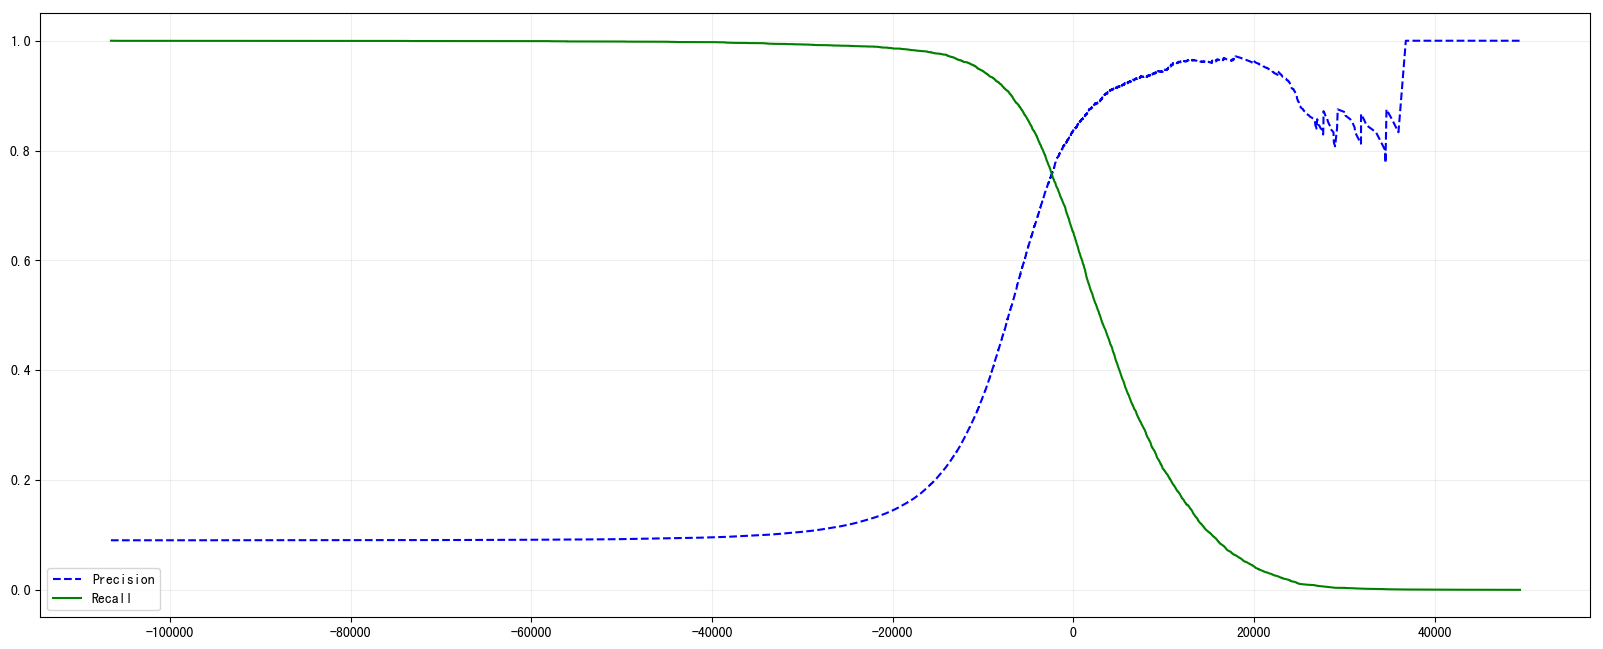

In [36]:
plot_precision_recall_vs_thresholds(precisions,recalls,thresholds)
plt.show()

假设你决定取90%的精确度，可以用np.argmax()，会给你最大值的第一个索引。

In [37]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.9)]
threshold_90_precision

3370.019499143958

In [38]:
# 如果要进行预测也可以用如下的方法(训练集)
y_train_pred_90=(y_scores>=threshold_90_precision)

In [39]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [40]:
# 再观察精确度和召回率
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

## ROC曲线
- TPR=TP/(TP+FN)
- FPR=FP/(TN+FP)

In [42]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)
# 计算多种阈值的TPR和FPR

In [43]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis()
    plt.grid(alpha=0.5)

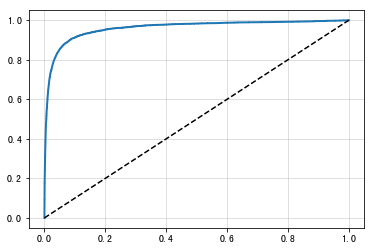

In [44]:
plot_roc_curve(fpr,tpr)
plt.show()

可以测量曲线下的面积AUC。完美的分类器的ROC曲线 AUC等于1,而随机分类器的ROC曲线 AUC等于0.5。

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

我们再来训练一个随机森林分类器。将其ROC曲线和SGDClassifier的ROC曲线作对比。

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')
# RandomForestClassifier只提供dict_pro()方法返回某一类别的概率，无decision_function()

In [48]:
# roc_curve需要提供标签和分数，所以我们用正类的概率作为分数值
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [49]:
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [50]:
y_scores_forest=y_probas_forest[:,1]
# score=proba of positive class
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)

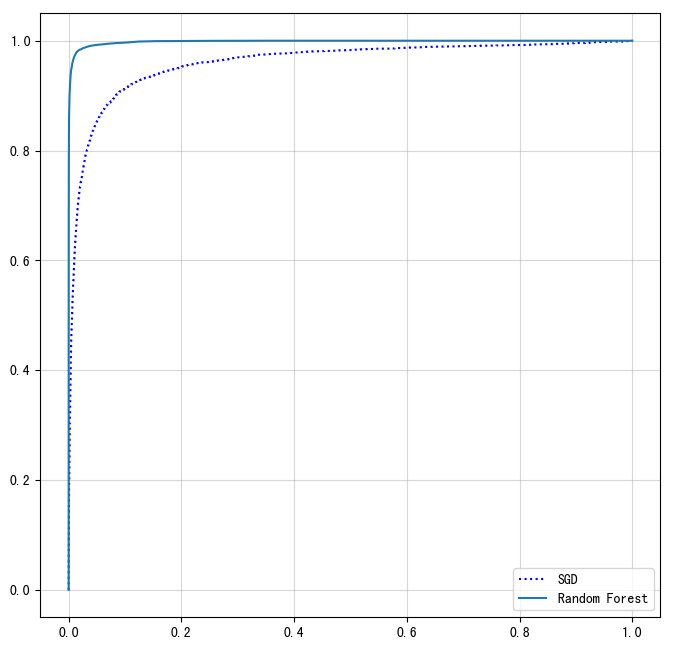

In [51]:
plt.figure(figsize=(8,8),dpi=100)
plt.plot(fpr,tpr,'b:',label='SGD')
plt.plot(fpr_forest,tpr_forest,label='Random Forest')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [52]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

# 多类分类器
- 第一种方法是训练是个2类分类器，哪个分类器给分最高分为哪个类。OVR一对多策略。
- 第二种方法是每一对数字训练一个二元分类器，一个区分0和1，一个区分0和2......最后看哪个类获胜的多。OVO一对一策略。

In [53]:
# sklearn自动检测需要使用二元分类还是多元分类
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
# 查看一下类别所对应的分数
some_digit_scores=svm_clf.decision_function([some_digit])

In [55]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [56]:
np.argmax(some_digit_scores)

5

In [57]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

使用OneVsOneClassifier或者OneVsRestClassifier强制使用一对一或者一对剩余策略

In [58]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

交叉验证SGDClassifier的准确性

In [61]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

若对输入进行简单放缩，则准确率会有所提高。

In [62]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))

In [63]:
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# 误差分析
假设你已经找到一个有潜力的模型，希望找到一些方法对他做进一步改进，其中一个方法就是分析其错误类型。

In [64]:
# 先看一眼混淆矩阵
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)

In [65]:
conf_mx
# 每行代表实际类，每列代表预测类

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

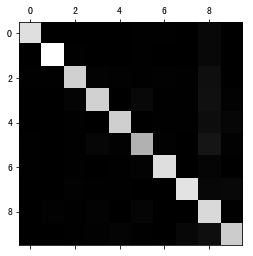

In [67]:
# 用图像来表示混淆矩阵
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

大多数图片都在主对角线上，证明其大多都被正确分类，但5却稍暗。

In [68]:
# 将混淆矩阵中的每个值除以相应类的数量
row_nums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_nums

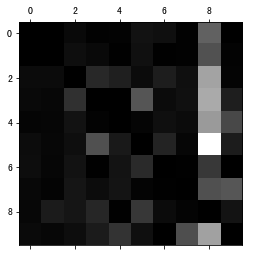

In [70]:
# 在对角线上填上0
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

每行代表实际类，每列代表预测类。可以看出很多图像都被预测成了8。3和5也经常搞混。

所以我们可以增加一些8的数据集来解决错误。对于3和5的分析见书。